<a href="https://colab.research.google.com/github/superbunny38/2021MachineLearning/blob/main/seminar/ClickThroughPredictionwithDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Click through Prediction with Decision Tree classifier

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
import gc
import time
import itertools
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score

## Get dataset from kaggle

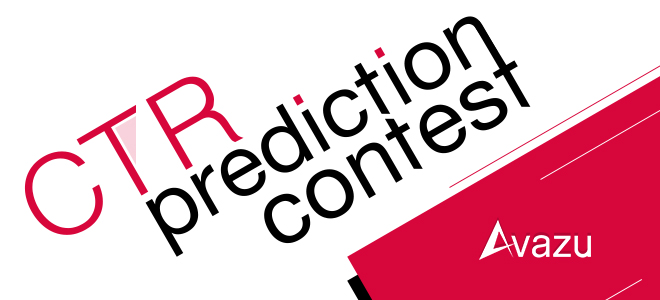

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/home/ubuntu/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=11dd94afc337c1ddbb943d0b785bf23f7047046accb50956f096af21ec434361
  Stored in directory: /home/ubuntu/.cache/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle


In [ ]:
!kaggle competitions download -c avazu-ctr-prediction

100%|█████████████████████████████████████▉| 1.19G/1.19G [01:07<00:00, 24.6MB/s]
100%|██████████████████████████████████████| 1.19G/1.19G [01:07<00:00, 19.0MB/s]


load test data

In [ ]:
!unzip avazu-ctr-prediction.zip

Archive:  avazu-ctr-prediction.zip
  inflating: sampleSubmission.gz     
  inflating: test.gz                 
  inflating: train.gz                


In [ ]:
test_file = "test.gz"
test = pd.read_csv(test_file, compression='gzip')

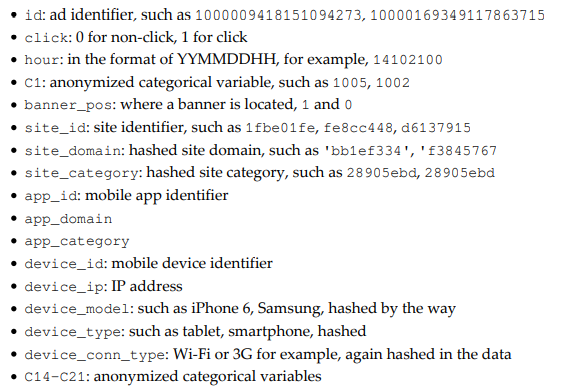

In [ ]:
test.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
2,1.000055e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
3,1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,...,1,0,18648,320,50,1092,3,809,100156,61
4,1.000138e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,...,1,0,23160,320,50,2667,0,47,-1,221


size of train dataset is very big, so need to divide into chunks

In [ ]:
train_file = "train.gz"
reader = pd.read_csv(train_file, chunksize=10**6, iterator=True)

train = pd.DataFrame()
start = time.time()

for i, chunk in enumerate(reader): 
    chunk = chunk.sample(frac=.65, replace=False, random_state=516)
    neg_samp = chunk[chunk['click'] == 0].sample(n=len(chunk[chunk['click'] == 1]), random_state=2021)
    train = pd.concat([train, neg_samp, chunk[chunk['click'] == 1]], axis=0)  
    if i % 20 == 0:
        print('Processing Chunk No. {}'.format(i))

print('the program costs %.2f seconds'%(time.time() - start))

del neg_samp
gc.collect()

print('train has {} rows and {} columns'.format(train.shape[0], train.shape[1]))
print('test has {} rows and {} columns'.format(test.shape[0], test.shape[1]))

Processing Chunk No. 0
Processing Chunk No. 20
Processing Chunk No. 40
the program costs 213.54 seconds
train has 8925858 rows and 24 columns
test has 4577464 rows and 23 columns


In [ ]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
740545,1.521976e+19,0,14102104,1005,1,e023ba3e,75f9ddc3,f028772b,ecad2386,7801e8d9,...,1,0,21153,320,50,2420,2,35,-1,69
491413,1.237389e+19,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,1,0,17753,320,50,1993,2,1063,100084,33
771247,1.717520e+19,0,14102104,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,...,1,0,16208,320,50,1800,3,167,100077,23
348689,1.739074e+19,0,14102102,1005,0,85f751fd,c4e18dd6,50e219e0,795a164e,2347f47a,...,1,0,21647,320,50,2487,1,547,100001,51
158412,1.475080e+19,0,14102101,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20366,320,50,2333,0,39,-1,157


In [ ]:
train.reset_index(drop=True)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.521976e+19,0,14102104,1005,1,e023ba3e,75f9ddc3,f028772b,ecad2386,7801e8d9,...,1,0,21153,320,50,2420,2,35,-1,69
1,1.237389e+19,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,1,0,17753,320,50,1993,2,1063,100084,33
2,1.717520e+19,0,14102104,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,...,1,0,16208,320,50,1800,3,167,100077,23
3,1.739074e+19,0,14102102,1005,0,85f751fd,c4e18dd6,50e219e0,795a164e,2347f47a,...,1,0,21647,320,50,2487,1,547,100001,51
4,1.475080e+19,0,14102101,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20366,320,50,2333,0,39,-1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8925853,1.312272e+19,1,14103023,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,...,1,2,23160,320,50,2667,0,47,-1,221
8925854,5.040032e+18,1,14103023,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,22815,320,50,2647,2,39,100148,23
8925855,8.002520e+18,1,14103021,1005,0,4bf5bbe2,6b560cc1,28905ebd,ecad2386,7801e8d9,...,1,0,22624,320,50,2374,3,39,-1,23
8925856,2.634610e+18,1,14103021,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,...,1,2,23160,320,50,2667,0,47,-1,221


In [ ]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
740545,1.521976e+19,0,14102104,1005,1,e023ba3e,75f9ddc3,f028772b,ecad2386,7801e8d9,...,1,0,21153,320,50,2420,2,35,-1,69
491413,1.237389e+19,0,14102103,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,1,0,17753,320,50,1993,2,1063,100084,33
771247,1.717520e+19,0,14102104,1005,1,b7e9786d,b12b9f85,f028772b,ecad2386,7801e8d9,...,1,0,16208,320,50,1800,3,167,100077,23
348689,1.739074e+19,0,14102102,1005,0,85f751fd,c4e18dd6,50e219e0,795a164e,2347f47a,...,1,0,21647,320,50,2487,1,547,100001,51
158412,1.475080e+19,0,14102101,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20366,320,50,2333,0,39,-1,157


#### shuffle data

In [ ]:
from sklearn.utils import shuffle
train = shuffle(train)
test = shuffle(test)

In [ ]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
28739433,1.775597e+19,1,14102809,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,1,0,23144,320,50,2665,0,34,100070,221
7000348,4.609652e+17,1,14102211,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15708,320,50,1722,0,35,-1,79
37706442,9.145271e+18,1,14103008,1005,0,325dbe14,373cce89,f028772b,ecad2386,7801e8d9,...,1,0,19772,320,50,2227,0,935,100077,48
17948515,4.297616e+18,1,14102511,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,...,1,0,19950,320,50,1800,3,167,100075,23
18755767,1.372269e+19,1,14102515,1005,0,6256f5b4,28f93029,f028772b,ecad2386,7801e8d9,...,1,0,21276,320,50,2443,2,39,-1,23


In [ ]:
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [ ]:
len(train.columns)

24

In [ ]:
test.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
1154107,5.292171e+18,14103107,1005,1,5b4d2eda,16a36ef3,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,21893,320,50,2526,0,167,100079,221
3923939,3.486957e+18,14103118,1005,0,17d1b03f,f3845767,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,23563,320,50,2701,0,35,-1,51
3778710,9.250585e+17,14103117,1005,0,6256f5b4,28f93029,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,24092,320,50,2761,2,35,100188,13
1234352,9.869577e+18,14103107,1005,0,b99a2c43,cc962a1f,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,24132,320,50,2768,1,33,-1,71
3433745,1.767858e+19,14103116,1005,0,85f751fd,c4e18dd6,50e219e0,92f5800b,ae637522,0f2161f8,...,1,0,23855,320,50,2734,1,175,100189,71


In [ ]:
train.to_csv("train.csv", index = False)
test.to_csv("test.csv", index = False)

## Read data in a dictionary

In [ ]:
import csv

def read_ad_click_data(n, offset=0):
    X_dict, y = [], []
    with open('train.csv', 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for i in range(offset):
            next(reader)
        i = 0
        for row in reader:
            i += 1
            y.append(int(row['click']))
            del row['click'], row['id'], row['hour'], row['device_id'], row['device_ip']#remove irrelevant features
            X_dict.append(dict(row))
            if i >= n:
                break
    return X_dict, y

In [ ]:
n = 100000#only use 100000 training samples
X_dict_train, y_train = read_ad_click_data(n)

In [ ]:
print(X_dict_train[0])#first training sample (hashed values for privacy)
print(X_dict_train[1])#second training sample (hashed values for privacy)

{'C1': '1005', 'banner_pos': '1', 'site_id': 'd9750ee7', 'site_domain': '98572c79', 'site_category': 'f028772b', 'app_id': 'ecad2386', 'app_domain': '7801e8d9', 'app_category': '07d7df22', 'device_model': 'd6e0e6ff', 'device_type': '1', 'device_conn_type': '0', 'C14': '23144', 'C15': '320', 'C16': '50', 'C17': '2665', 'C18': '0', 'C19': '34', 'C20': '100070', 'C21': '221'}
{'C1': '1005', 'banner_pos': '0', 'site_id': '1fbe01fe', 'site_domain': 'f3845767', 'site_category': '28905ebd', 'app_id': 'ecad2386', 'app_domain': '7801e8d9', 'app_category': '07d7df22', 'device_model': '1f0bc64f', 'device_type': '1', 'device_conn_type': '0', 'C14': '15708', 'C15': '320', 'C16': '50', 'C17': '1722', 'C18': '0', 'C19': '35', 'C20': '-1', 'C21': '79'}


In [ ]:
len(X_dict_train)#length of dictionary

100000

In [ ]:
len(X_dict_train[0])#number of attributes(==textbook)

19

In [ ]:
len(y_train)

100000

## Encode Data

**DictVectorizer: converts a categorical feature with k possible values into k binary features.**


ex.)

In [ ]:
from sklearn.feature_extraction import DictVectorizer
#example usage of DictVectorizer for one-hot encoding
sample = [{'ch':'-1', 'a':'0.2','ee':'hello'},{'ch':'0','a':'2'}, {'ee': 'hi'}] 
tmp_encoder = DictVectorizer(sparse = False)
sample_d = tmp_encoder.fit_transform(sample)

In [ ]:
sample_d# ch==-1 | ch==0 | a == 0.2 | a == 2 | ee==hello | ee == hi

array([[1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
from sklearn.feature_extraction import DictVectorizer
dict_one_hot_encoder = DictVectorizer(sparse=False)
X_train = dict_one_hot_encoder.fit_transform(X_dict_train)

In [ ]:
len(X_train)

100000

In [ ]:
len(X_train[0])

9694

In [ ]:
X_train[0]#first training datasample

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
X_dict_test, y_test = read_ad_click_data(n, n)

In [ ]:
X_test = dict_one_hot_encoder.transform(X_dict_test)

In [ ]:
X_test[0]#first testing datasample

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
len(X_test)

100000

In [ ]:
print(len(X_test[0]))

9694


Difference exists for values of len(X_train[0]), len(X_test[0]) between this code output, and the textbook. It is because of the code for reading training sample is different( -> training dataset in the textbook != training dataset in this code)

## Train a Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth': [2, 3, 10, None]}#try training with max_depth with different values
decision_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=30)

In [ ]:
from sklearn.model_selection import GridSearchCV#Exhaustive search over specified parameter values for an estimator.
grid_search = GridSearchCV(decision_tree, parameters, cv=3, scoring='roc_auc')

In [ ]:
grid_search.fit(X_train, y_train)#train

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(min_samples_split=30),
             param_grid={'max_depth': [2, 3, 10, None]}, scoring='roc_auc')

In [ ]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_split=30)

find best parameter

In [ ]:
print(grid_search.best_params_)

{'max_depth': 10}


In [ ]:
from pylab import *
decision_tree_best = grid_search.best_estimator_#get the best classifier
pos_prob = decision_tree_best.predict_proba(X_test)[:, 1]#predict

in the text book: 0.692

In [ ]:
from sklearn.metrics import roc_auc_score
print('The ROC AUC on testing set is: {0:.3f}'.format(roc_auc_score(y_test, pos_prob)))

The ROC AUC on testing set is: 0.676


In [ ]:
pos_prob

array([0.41407185, 0.17550159, 0.13790859, ..., 0.87188453, 0.61865615,
       0.76803442])

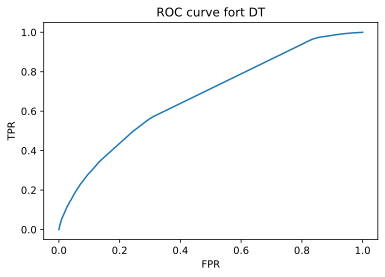

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
fpr, tpr, _ = roc_curve(y_test, pos_prob)

plt.clf()
plt.plot(fpr, tpr,label="DT")
plt.plot()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve fort DT')
plt.show()

# Random Forest

#### Hyper parameters of Random Forest:
- max_features:
    The number of features to consider at each best splitting point search.
- n_estimators:
    The number of trees considered for majority voting
- min_samples_split:
    Minimal number of samples required for further split at a node.(ex. 10,30,50,...)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=30, n_jobs=-1)
grid_search = GridSearchCV(random_forest, parameters, cv=3, scoring='roc_auc')

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(min_samples_split=30, n_jobs=-1),
             param_grid={'max_depth': [2, 3, 10, None]}, scoring='roc_auc')

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': None}
0.7258407193811719


In [ ]:
from sklearn.metrics import roc_auc_score
random_forest_best = grid_search.best_estimator_
pos_prob_rf = random_forest_best.predict_proba(X_test)[:, 1]
print(f'The ROC AUC on testing set is: {roc_auc_score(y_test, pos_prob_rf):.3f}')

The ROC AUC on testing set is: 0.729


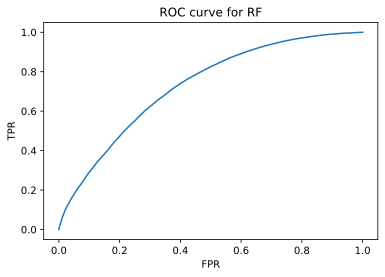

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
fpr, tpr, _ = roc_curve(y_test, pos_prob_rf)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for RF')
plt.show()

# Boost

In [ ]:
pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.6/173.6 MB 9.2 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
df = pd.read_csv("train.csv", nrows=n_rows)

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
X = df.drop(['click', 'id', 'hour', 'device_id', 'device_ip'], axis=1).values
Y = df['click'].values

In [ ]:
n_train = 100000

In [ ]:
len(X_train)

270000

In [ ]:
#n_train = int(n_rows * 0.9)
X_train = X[:n_train]
Y_train = Y[:n_train]
X_test = X[n_train:]
Y_test = Y[n_train:]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
X_train_enc = enc.fit_transform(X_train)
X_test_enc = enc.transform(X_test)

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=1000)

In [ ]:
model.fit(X_train, y_train, verbose = 0)

[08:35:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [ ]:
pos_prob_xgb = model.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score
print(f'The ROC AUC on testing set is: {roc_auc_score(y_test, pos_prob_xgb):.3f}')

### AdaBoost

#### Hyper parameters of AdaBoost:
- learning rate: Weight applied to each classifier at each boosting iteration. A higher learning rate increases the contribution of each classifier.
- n_estimators: The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(learning_rate=0.1, n_estimators=100)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
pos_prob_ada = model.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score
print(f'The ROC AUC on testing set is: {roc_auc_score(y_test, pos_prob_ada):.3f}')

### LightGBM

In [ ]:
pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.0 MB/s eta 0:00:0031m28.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=200)
model = lgbm.fit(X_train, y_train)

In [ ]:
pos_prob_lgbm = model.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score
print(f'The ROC AUC on testing set is: {roc_auc_score(y_test, pos_prob_lgbm):.3f}')

The ROC AUC on testing set is: 0.736


## Comparison of ROC for DecisionTree, RandomForest, Boosting

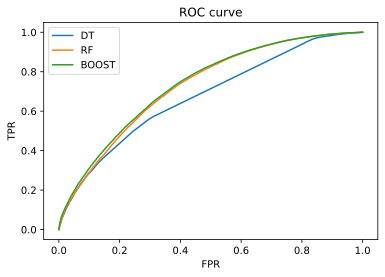

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_test, pos_prob)
fpr1, tpr1, _ = roc_curve(y_test, pos_prob_rf)
fpr2, tpr2, _ = roc_curve(y_test, pos_prob_lgbm)

plt.clf()
plt.plot(fpr, tpr,label="DT")
plt.plot(fpr1, tpr1,label="RF")
plt.plot(fpr2, tpr2,label="BOOST")
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()